<a href="https://colab.research.google.com/github/wanghongree/temp_drafts/blob/main/calibrate_CIFAR10_pre_check_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import os
import shutil
import cv2
import pandas as pd

2022-12-29 22:17:58.971996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 22:17:59.102084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-29 22:17:59.102108: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-29 22:17:59.762365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-12-29 22:18:00.930277: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hrw/Work/temp_drafts/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-29 22:18:00.930353: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-29 22:18:00.930385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vm22): /proc/driver/nvidia/version does not exist


In [5]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [6]:
# Make sure images have shape (32, 32, 1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
from keras.models import load_model
model = load_model('model.h5')

2022-12-29 22:18:01.783210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
yhat = model.predict(x_test)
y_predicted = np.argmax(yhat, axis = 1)
y_true = np.argmax(y_test, axis=1)
test_result = pd.DataFrame({'predicted': y_predicted, 'true':y_true})
test_result['correct'] = (test_result['predicted'] == test_result['true'])
summary = test_result.groupby(['true'])['correct'].agg(correct = 'sum', total = 'count')
summary['correction_rate'] = summary['correct'] / summary['total'] * 100


313/313 [==============================] - 9s 28ms/step


In [9]:
summary

,correct,total,correction_rate
true,,,
0,891,1000,89.1
1,905,1000,90.5
2,800,1000,80.0
3,617,1000,61.7
4,827,1000,82.7
5,782,1000,78.2
6,848,1000,84.8
7,865,1000,86.5
8,866,1000,86.6


In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
confusion_matrix(test_result['true'], test_result['predicted'])

array([[891,  13,  34,   5,   9,   2,   6,   4,  20,  16],
       [ 18, 905,   4,   3,   3,   2,   1,   2,   6,  56],
       [ 43,   1, 800,  20,  57,  25,  25,  16,   8,   5],
       [ 27,   9,  77, 617,  60, 121,  34,  33,   8,  14],
       [ 10,   1,  68,  16, 827,  22,  14,  38,   3,   1],
       [ 10,   2,  45,  76,  40, 782,  10,  30,   0,   5],
       [  9,   3,  61,  21,  36,  13, 848,   5,   1,   3],
       [ 13,   1,  31,  13,  43,  26,   1, 865,   0,   7],
       [ 78,  15,   8,   4,   0,   2,   6,   4, 866,  17],
       [ 22,  40,   5,   1,   0,   1,   1,   5,  10, 915]])

In [12]:
# given a category, show the images that are misclassified
def show_misclassified_images(category):
    misclassified = test_result[(test_result['true'] == category) & (test_result['correct'] == False)]
    for i in range(0, 5):
        img = x_test[misclassified.index[i]] * 255
        cv2.imshow(str(misclassified.index[i]), img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [33]:
# given two categories, show the images that are misclassified
def show_misclassified_images_random(category1, category2, sample_size = 1):
    misclassified = test_result[(test_result['true'] == category1) & (test_result['correct'] == False)]
    misclassified = misclassified[misclassified['predicted'] == category2]
    picked = misclassified.sample(sample_size).index
    for i in picked:
        img = x_test[i]
        plt.imshow(img)
        plt.show()

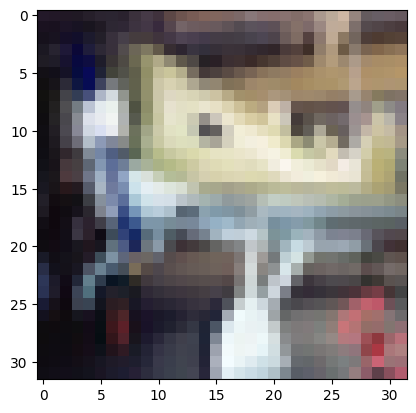

In [46]:
show_misclassified_images(0, 1, 1)

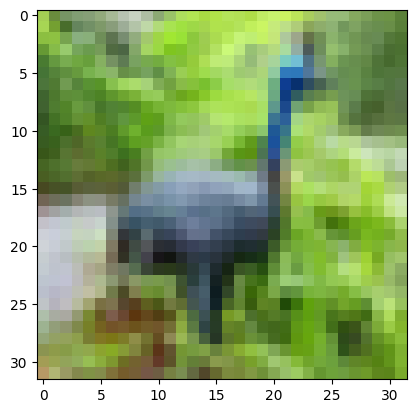

In [17]:
img = x_train[6] 
plt.imshow(img)